In [14]:
import os

# Check if the file exists and remove it
if os.path.isfile('MS3.csv'):
    os.remove('MS3.csv')

# Now upload your file
from google.colab import files
uploaded = files.upload()

Saving MS3.csv to MS3.csv


In [15]:
import pandas as pd

df=pd.read_csv('MS3.csv')

In [16]:
import io

df = pd.read_csv(io.BytesIO(uploaded['MS3.csv']))
print(df.head())

   Term  Inv  Rev_mean  Rev_StdDev  C1_mean  C1_StdDev  C2_mean  C2_StdDev  \
0     0  -70         0           0        0          0        0          0   
1     1    0       120          50       40          5       30          5   
2     2    0       105          50       42          5       31          5   
3     3    0       110          60       44          5       32          5   

   C3_mean  C3_StdDev  R_mean  R_StdDev  Rev_AutoCorr  C1_AutoCorr  \
0        0          0    0.06      0.01           0.0          0.0   
1       10          1    0.06      0.01           0.0          0.0   
2       12          1    0.06      0.01           0.1          0.1   
3       13          1    0.06      0.01           0.2          0.2   

   C2_AutoCorr  C3_AutoCorr  Abandon_NPV  
0          0.0          0.0         -100  
1          0.0          0.0          -30  
2          0.1          0.1          -20  
3          0.2          0.2            0  


Expected NPV : 19.624444285987742
Probability of Negative NPV : 43.04%


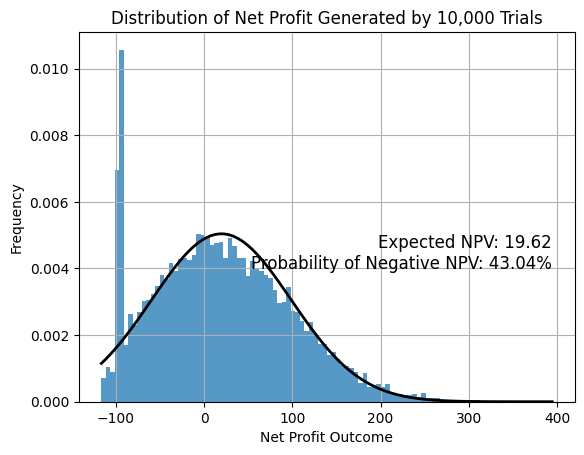

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set the number of simulations
num_simulations = 10000

# Initialize arrays to store previous values
prev_values = {
    'Rev': np.zeros(df.shape[0]),
    'C1': np.zeros(df.shape[0]),
    'C2': np.zeros(df.shape[0]),
    'C3': np.zeros(df.shape[0]),
}

# Initialize an empty array to hold the NPV for each simulation
npv_array = np.zeros(num_simulations)

# Loop over each simulation
for i in range(num_simulations):
    cashflows = np.zeros(df.shape[0])
    for index, row in df.iterrows():
        # Generate revenues and costs for this stage, taking into account autocorrelation
        rev = np.random.normal(row['Rev_mean'], row['Rev_StdDev'])
        c1 = np.random.normal(row['C1_mean'], row['C1_StdDev'])
        c2 = np.random.normal(row['C2_mean'], row['C2_StdDev'])
        c3 = np.random.normal(row['C3_mean'], row['C3_StdDev'])
        
        if index > 0:
            rev += row['Rev_AutoCorr'] * (prev_values['Rev'][index-1] - df.loc[index-1, 'Rev_mean'])
            c1 += row['C1_AutoCorr'] * (prev_values['C1'][index-1] - df.loc[index-1, 'C1_mean'])
            c2 += row['C2_AutoCorr'] * (prev_values['C2'][index-1] - df.loc[index-1, 'C2_mean'])
            c3 += row['C3_AutoCorr'] * (prev_values['C3'][index-1] - df.loc[index-1, 'C3_mean'])
        
        # Store the generated values for the next iteration
        prev_values['Rev'][index] = rev
        prev_values['C1'][index] = c1
        prev_values['C2'][index] = c2
        prev_values['C3'][index] = c3

        # Compute the net cash flow for this stage
        net_cashflow = rev - c1 - c2 - c3 + row['Inv']
        
        # Apply the discount rate
        discount_rate = np.random.uniform(row['R_mean'], row['R_StdDev'])
        discounted_cashflow = net_cashflow / (1 + discount_rate) ** (index + 1)
        
        # Check the real option condition, if applicable
        if discounted_cashflow < row['Abandon_NPV']:
            cashflows[index] = row['Abandon_NPV'] / (1 + discount_rate) ** (index + 1)
            break
        else:
            cashflows[index] = discounted_cashflow

    # Calculate the NPV for this simulation
    npv = cashflows.sum()
    npv_array[i] = npv

# Compute the expected NPV
expected_NPV = np.mean(npv_array)

# Compute the standard deviation of the NPV
std_NPV = np.std(npv_array)

# Compute the probability of a negative NPV
prob_of_negative_NPV = np.mean(npv_array < 0)

print(f"Expected NPV : {expected_NPV}")
print(f"Probability of Negative NPV : {prob_of_negative_NPV *100}%")

# Plot the distribution of NPVs
plt.hist(npv_array, bins=100, alpha=0.75, density=True)
plt.xlabel('Net Profit Outcome')
plt.ylabel('Frequency')
plt.title('Distribution of Net Profit Generated by 10,000 Trials')
plt.grid(True)

# Generate x values
x = np.linspace(min(npv_array), max(npv_array), 100)

# Generate normal distribution with same mean and standard deviation as your data
p = norm.pdf(x, expected_NPV, std_NPV)

# Plot normal distribution
plt.plot(x, p, 'k', linewidth=2)

# Add text to the upper right corner of the plot
plt.text(np.max(npv_array), np.max(p), 
         f'Expected NPV: {expected_NPV:.2f}\nProbability of Negative NPV: {prob_of_negative_NPV * 100:.2f}%', 
         verticalalignment='top', horizontalalignment='right', fontsize=12)

plt.show()

